<div style="text-align: center; width: 100%">
    <img src="imgs/logo.png" max-width=400px height="auto">
</div>

# Query Genomes by Chemical Compound Structure

In this notebook, we will query genomes based on the chemical structure of compounds. This process involves preprocessing reaction data, filtering databases by chemical compound structure, and retrieving genomes capable of producing the queried compounds. We will utilize various Python libraries such as RDKit for chemical fingerprinting and pandas for data manipulation.

## Preprocessing (optional)

In this section, we preprocess the reaction and compound data to generate a comprehensive dataframe that will be used for querying. The `preprocess_reactions` function converts the raw JSON data into a format suitable for analysis, while `process_reactions_to_dataframe` transforms the processed reactions into a pandas DataFrame, which is then saved as a TSV file for further use.

```python
from pathlib import Path
from chemsearch.preprocess import preprocess_reactions, process_reactions_to_dataframe

reactions_json = Path("../data/modelseed/reactions.json")
compounds_json = Path("..data/modelseed/compounds.json")

reactions = preprocess_reactions(reactions_json, compounds_json, complete_smiles=True)

df = process_reactions_to_dataframe(reactions)
df.to_csv("../data/compound_ec_database.tsv", sep="\t", index=False)
```

In [1]:
import pandas as pd

rxn_df = pd.read_csv("../data/compound_ec_database_plus_rhea.tsv", sep="\t")
rxn_df.head()

,compound_id,compound_name,SMILES,ec_numbers,reaction_ids
0,cpd00001,h2o,O,3.4.22.41;3.5.1.25;3.1.2.28;4.1.99.18;3.1.3.77...,R04975;RXN-8108.c;3.6.3.44-RXN.ce.metaexp.CPD-...
1,cpd00012,ppi,O=P([O-])([O-])OP(=O)([O-])O,6.1.1.20;2.7.7.4;6.1.-.-;4.1.99.18;2.7.7.86;6....,R01668;rxn1118_p;R_ANNATn;R02328;RXN-8577.c;JM...
2,cpd00009,pi,O=P([O-])([O-])O,5.6.1.i;2.4.2.2;3.6.1.64;4.2.3.5;6.3.3.2;3.6.3...,R_GLCPh;PNP1_11;JM_Cre_390;3.6.3.44-RXN.ce.met...
3,cpd00067,h,[H+],1.1.1.6;1.3.1.40;1.1.1.21;1.15.1.2;4.1.1.81;2....,NQOR-RXN.d.metaexp.2-HEXAPRENYL-3-METHYL-6-MET...
4,cpd00742,allphn,NC(=O)NC(=O)[O-],3.5.1.54;6.3.4.6;3.5.1.84,R_ALPHm;UREA-CARBOXYLASE-RXN.c;R00774;R_URCBm;...


## Filter Database by Chemical Compound Structure

We will use the RDKit library to compute chemical fingerprints from SMILES strings and compare them to the query compound through the Tanimoto distance. This allows us to measure the structural similarity between compounds.

We can input several SMILES strings simultaneously. Additionally, we can provide a list of similarity thresholds for each compound (where a value of 1 indicates a perfect structural match) or a single threshold value to be applied uniformly to all input compounds.

Here is a list of natural products as an example to query our genomes. These are sorted by market value:

In [2]:
import pandas as pd 

query_cpds = pd.read_csv(
    "../tests/high_value_NPs.tsv", sep="\t"
    ).sort_values("Market (USD 1 M)", ascending=False)
query_cpds

,Compound,Market (USD 1 M),Year,URL,SMILES,COCONUT ID
1,Astaxanthin,1500.00,2023,https://www.grandviewresearch.com/industry-ana...,O=C1C(=C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C(C...,CNP0190579
0,Beta-Carotene,427.40,2023,https://www.gminsights.com/industry-analysis/b...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,CNP0233748
2,Lutein,381.10,2023,https://www.globenewswire.com/news-release/202...,OC1C=C(C)C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C...,CNP0216202
5,Fucoxanthin,209.45,2023,https://www.maximizemarketresearch.com/market-...,O=C(OC1CC(O)(C(=C=CC(=CC=CC(=CC=CC=C(C=CC=C(C(...,CNP0233524
4,Canthaxanthin,125.90,2023,https://www.expertmarketresearch.com/reports/c...,O=C1C(=C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C(C...,CNP0355008
3,Zeaxanthin,61.48,2022,https://www.reportsanddata.com/report-detail/z...,OC1CC(=C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C(C...,CNP0283320


Let's visualize the molecular structures of our target compounds with RDKit:

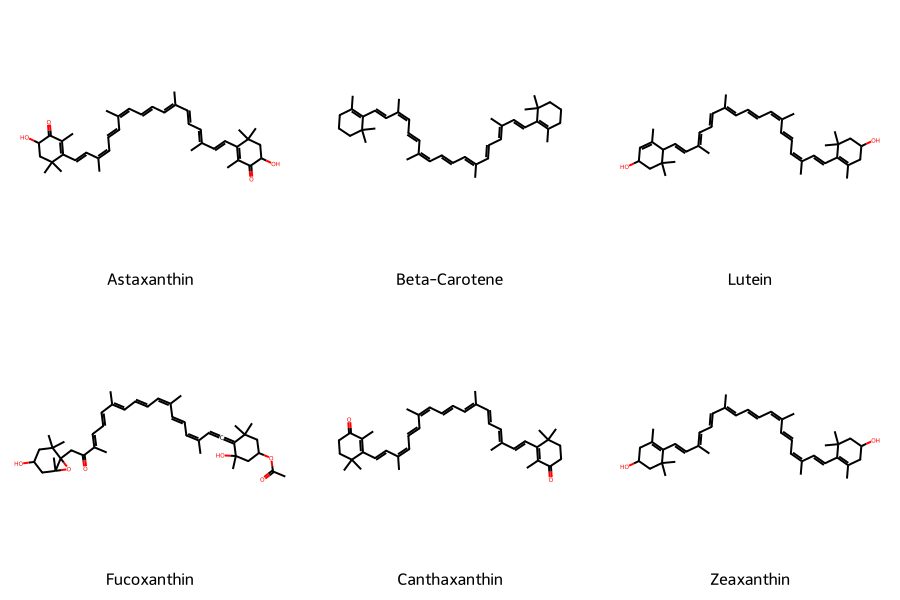

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw

target_smiles = query_cpds["SMILES"].tolist()
target_names = query_cpds["Compound"].tolist()
mols = [Chem.MolFromSmiles(smile) for smile in target_smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), legends=target_names)
img

In [5]:
from chemsearch.query import query_reaction_database_by_smiles

threshold = 0.7
res = query_reaction_database_by_smiles(rxn_df, target_smiles, threshold, only_best_hit=True)
res

,compound_id,compound_name,target_SMILES,query_SMILES,ec_numbers,reaction_ids,similarity
0,CHEBI:10223,alpha-cryptoxanthin,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,OC1C=C(C)C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C...,1.14.14.158,30399,0.837398
1,CHEBI:28425,alpha-carotene,CC1=CCCC(C)(C)C1/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,1.14.14.158,30399,0.746032
2,cpd01420,beta-Carotene,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,1.14.99.-;5.2.1.14;1.13.11.63;5.2.1.-;5.5.1.19...,R_CAROMO;RXN-8194.c;RXN-7883.c;rxn02707;RXN1F-...,1.000000
3,cpd03218,alpha-Carotene,CC1=CCCC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C)=C/C=C...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,1.14.99.-;1.14.14.158;5.5.1.19;1.14.13.129;5.5...,RXNBWI-7189.c;R06964;R_CHYA2;R07530;RXN-5961.d...,0.746032
4,cpd03637,Zeaxanthin,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,OC1CC(=C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C(C...,1.14.99.-;1.14.13.90;1.10.99.3;1.14.99.42;1.14...,RXN-7978.e.maizeexp.NADP_NADPH;RXN-10672.e;RXN...,1.000000
5,cpd05486,Antheraxanthin,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,OC1CC(=C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C(C...,5.3.99.8;1.14.13.90;1.10.99.3,RXN-7979.d.metaexp.NAD_NADH;RXN-7984.d;RXN-797...,0.736842
6,cpd05487,Astaxanthin,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,O=C1C(=C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C(C...,1.14.13.129;1.14.13.-,R08102;R07572;R_R07572_c;R07573;phoenicoxanthi...,1.000000
7,cpd05490,Canthaxanthin,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,O=C1C(=C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C(C...,1.14.13.129;1.14.13.-,R07568;canthaxanthin hydroxylase;R_R07568_c;R0...,1.000000
8,cpd05491,Capsanthin,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,OC1CC(=C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C(C...,5.3.99.8,R07321,0.742424
9,cpd05497,Zeinoxanthin,CC1=CCCC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C)=C/C=C...,OC1C=C(C)C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C...,1.14.99.-;1.14.13.129;1.14.99.45;1.14.13.-,RXN-5961.d;R07530;reac_838;R_R07530_c;R07531;R...,0.837398


## Retrieving genomes producing the query compound

Next, we will identify genomes that can produce the target compounds. We start by querying the reaction database with the given SMILES strings and a predefined similarity threshold.

In [6]:
from chemsearch.preprocess import parse_genome_ec_numbers

directory_path = "../data/genomes_ec"
genome_data = parse_genome_ec_numbers(directory_path)

Now we are ready to query our genomes for the target compounds.

In [7]:
from chemsearch.query import extract_genome_hits

hits = extract_genome_hits(res, genome_data, taxonomy='../data/taxonomy_mapping.tsv')
hits.to_csv("../tests/hits.tsv", sep="\t", index=False)
hits

,genome,sequence_ID,ec_number,compound_name,target_SMILES,query_SMILES,similarity,taxonomy
0,TARA_ARC_108_MAG_00117,TARA_ARC_108_MAG_00117_000000000264_12,1.13.11.63,beta-Carotene,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,1.000000,Bacteria; Proteobacteria; Alphaproteobacteria;...
1,TARA_ARC_108_MAG_00117,TARA_ARC_108_MAG_00117_000000000264_13,5.5.1.19,beta-Carotene,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,1.000000,Bacteria; Proteobacteria; Alphaproteobacteria;...
2,TARA_ARC_108_MAG_00117,TARA_ARC_108_MAG_00117_000000000264_13,5.5.1.19,alpha-Carotene,CC1=CCCC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C)=C/C=C...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,0.746032,Bacteria; Proteobacteria; Alphaproteobacteria;...
3,TARA_ARC_108_MAG_00117,TARA_ARC_108_MAG_00117_000000000264_13,5.5.1.19,"7,8-Dihydro-beta-carotene",CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,0.788618,Bacteria; Proteobacteria; Alphaproteobacteria;...
4,TARA_ARC_108_MAG_00201,TARA_ARC_108_MAG_00201_000000000048_5,1.13.11.63,beta-Carotene,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,1.000000,Bacteria; Bacteroidota; Bacteroidia; Flavobact...
5,TARA_ARC_108_MAG_00201,TARA_ARC_108_MAG_00201_000000000080_2,5.5.1.19,beta-Carotene,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,1.000000,Bacteria; Bacteroidota; Bacteroidia; Flavobact...
6,TARA_ARC_108_MAG_00201,TARA_ARC_108_MAG_00201_000000000080_2,5.5.1.19,alpha-Carotene,CC1=CCCC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C)=C/C=C...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,0.746032,Bacteria; Bacteroidota; Bacteroidia; Flavobact...
7,TARA_ARC_108_MAG_00201,TARA_ARC_108_MAG_00201_000000000080_2,5.5.1.19,"7,8-Dihydro-beta-carotene",CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C=C/C=C(C)/C=C/C=...,C(=CC=C(C=CC=C(C=CC1=C(C)CCCC1(C)C)C)C)C=C(C=C...,0.788618,Bacteria; Bacteroidota; Bacteroidia; Flavobact...


In this notebook, we demonstrated a method to query genomes based on chemical compound structures by preprocessing reaction and compound data, filtering by structural similarity using RDKit, and identifying relevant genomes. This approach is valuable for identifying genomes capable of producing target compounds, useful in bioprospecting and synthetic biology.